# Read in multiple years of SST data

The 1981 to 2015 data is not available via s3 is seems:
https://search.earthdata.nasa.gov/search/granules/collection-details?p=C1652971997-PODAAC&pg[0][v]=f&pg[0][gsk]=-start_date&q=OI%20Global&fs10=Sea%20Surface%20Temperature&fsm0=Ocean%20Temperature&fst0=Oceans&m=60.46875!-144.9140625!2!1!0!0%2C2

The v2.1 data says it is 1981 to present, but only 2016 to present is shown.


---

### Import Required Packages

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import s3fs
import pandas as pd
import numpy as np
import xarray as xr
import geopandas
import hvplot.xarray
from pystac_client import Client
from pathlib import Path
import os
#gv.extension('bokeh', 'matplotlib')

# Workflow

* Download file and open as xarray object.
* Compute my nearshore and offshore metrics
    * *Ques: How to I add the time component?*
* Go to the next file
* Repeat

## Step 1 Get the http links to the files

In [18]:
http_links = open('../data/IOv2-links.txt').read().splitlines()
http_links[0:3]

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/1981/244/19810901120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/1981/245/19810902120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/1981/246/19810903120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc']

## Step 2 Write a function to download one file and store to xarray

In [14]:
r = requests.get(http_links[0])
outfile = "../data/temp"
with open(outfile, 'wb') as f:
        f.write(r.content)

In [16]:
sst_xr = xr.open_dataset(outfile)
sst_xr

<xarray.Dataset>
Dimensions:           (time: 1, lat: 720, lon: 1440, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 1981-09-01
Dimensions without coordinates: nv
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    time_bnds         (time, nv) datetime64[ns] ...
Attributes: (12/47)
    product_version:            Version 2.0
    spatial_resolution:         0.25 degree
    Conventions:                CF-1.6,ACDD-1.3
    title:                      NCEI global 0.25 deg daily sea surface temper...
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NCEI
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v29
    source:                     AVHRR_Pathfinder-NODC-L3C-v5.1,ICOADS_SHIP-NC...
    summary:                    NOAA's 1/4-degree Daily Optimum Interpolation...
    time_coverage_start:        19810901T000000Z
    time_coverage_end:          19810902T000000Z
    uuid:                       39832cc3-d409-438a-820e-2bb1b38ebca8

In [64]:
def getxarray(url):
    outfile = "../data/temp"
    if Path(outfile).exists():
        os.remove(outfile)
    r = requests.get(url)
    with open(outfile, 'wb') as f: f.write(r.content)
    sst_xr = xr.open_dataset(outfile)
    return sst_xr

In [65]:
# Works
getxarray(http_links[0])

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [62]:
http_links[0:2]

['https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/1981/244/19810901120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc',
 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/NCEI/AVHRR_OI/v2/1981/245/19810902120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.0.nc']

## Step 3 add this to xarray with the time element

In [59]:
sstxr2

<xarray.Dataset>
Dimensions:           (time: 1, lat: 720, lon: 1440, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 1981-09-01
Dimensions without coordinates: nv
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    time_bnds         (time, nv) datetime64[ns] ...
Attributes: (12/47)
    product_version:            Version 2.0
    spatial_resolution:         0.25 degree
    Conventions:                CF-1.6,ACDD-1.3
    title:                      NCEI global 0.25 deg daily sea surface temper...
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NCEI
    ...                         ...
    standard_name_vocabulary:   CF Standard Name Table v29
    source:                     AVHRR_Pathfinder-NODC-L3C-v5.1,ICOADS_SHIP-NC...
    summary:                    NOAA's 1/4-degree Daily Optimum Interpolation...
    time_coverage_start:        19810901T000000Z
    time_coverage_end:          19810902T000000Z
    uuid:                       39832cc3-d409-438a-820e-2bb1b38ebca8

In [63]:
sstxr1 = getxarray(http_links[0])
sstxr2 = getxarray(http_links[1])

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [57]:
xr.concat(sstxr1, sstxr2)

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'str'>

In [3]:
%%capture
import requests

def store_aws_keys(endpoint: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):    
    with requests.get(endpoint, "w") as r:
        accessKeyId, secretAccessKey, sessionToken, expiration = list(r.json().values())
    %set_env AWS_ACCESS_KEY_ID=$accessKeyId
    %set_env AWS_SECRET_ACCESS_KEY=$secretAccessKey
    %set_env AWS_SESSION_TOKEN=$sessionToken
    return expiration

exp = store_aws_keys()

In [2]:
from pystac_client import Client

In [82]:
# Get credentials
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
}
def get_temp_creds():
    temp_creds_url = s3_cred_endpoint['podaac']
    return requests.get(temp_creds_url).json()
temp_creds_req = get_temp_creds()

Search the client and find the files with the collection id.

In [74]:
podaac_cat = Client.open('https://cmr.earthdata.nasa.gov/stac/POCLOUD/')
search = podaac_cat.search(
    collections=['AVHRR_OI-NCEI-L4-GLOB-v2.1'],
    datetime='2016/2020'
)

Here are the number of files matched. Since it is 5 years and 2020 was a leap year, there should be 1827 files.

In [64]:
365*5+2

1827

In [75]:
search.matched()

1827

These lines get the urls and convert to s3 urls."

In [76]:
items = search.get_all_items()

In [77]:
sst_https = items[1].get_assets()['data'].href
sst_https

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160102120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'

In [25]:
sst_s3 = sst_https.replace('https://archive.podaac.earthdata.nasa.gov/', 's3://')
sst_s3

's3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160102120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'

Create the https urls from the items.

In [78]:
sst_https_urls = [x.get_assets()['data'].href for x in items]
sst_https_urls[0]

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'

Create the s3 urls by replacing the https part with the s3 part.

In [79]:
sst_s3_urls = [x.replace('https://archive.podaac.earthdata.nasa.gov/', 's3://') for x in sst_https_urls]
sst_s3_urls[0]

's3://podaac-ops-cumulus-protected/AVHRR_OI-NCEI-L4-GLOB-v2.1/20160101120000-NCEI-L4_GHRSST-SSTblend-AVHRR_OI-GLOB-v02.0-fv02.1.nc'

In [80]:
len(sst_s3_urls)

1827

## Set up file access credentials

In [84]:
fs_s3 = s3fs.S3FileSystem(anon=False, key=temp_creds_req['accessKeyId'], secret=temp_creds_req['secretAccessKey'], token=temp_creds_req['sessionToken'])

## Single file in-region direct S3 access of netcdf file

In [85]:
%%time
s3_file_obj = fs_s3.open(sst_s3_urls[0], mode='rb')
sst_xr = xr.open_dataset(s3_file_obj, engine='h5netcdf')

CPU times: user 112 ms, sys: 8.17 ms, total: 120 ms
Wall time: 240 ms


In [32]:
sst_xr

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1440, time: 1, nv: 2)
Coordinates:
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time              (time) datetime64[ns] 2016-01-01
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 -90.0 -89.75 -89.75 ... 89.75 89.75 90.0
    lon_bnds          (lon, nv) float32 -180.0 -179.8 -179.8 ... 179.8 180.0
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    id:                         NCEI-L4LRblend-GLOB-AVHRR_OI
    references:                 Reynolds, et al.(2009) What is New in Version...
    institution:                NOAA/NESDIS/NCEI
    creator_name:               NCEI Products and Services
    ...                         ...
    Metadata_Link.:             http://doi.org/10.7289/V5SQ8XB5
    keywords:                   Oceans>Ocean Temperature>Sea Surface Temperature
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   CF Standard Name Table v29
    processing_level:           L4
    cdm_data_type:              Grid

Should take about 19 seconds per year.

In [33]:
54*0.001*365

19.71

## Multi-file in-region direct S3 access of netcdf files

In [86]:
%%time
# Iterate through remote_files to create a fileset
fileset = [fs_s3.open(file) for file in sst_s3_urls]
# This works
sst_xr_ts = xr.open_mfdataset(fileset, engine='h5netcdf')
# chunks doesn't seem to make it faster
#sst_xr_ts = xr.open_mfdataset(fileset, engine='h5netcdf', chunks= {'time':1096, 'lat':100, 'lon':100})

CPU times: user 2min 7s, sys: 4.95 s, total: 2min 11s
Wall time: 5min 45s


In [ ]:
#sst_xr_ts.analysed_sst.hvplot.image()

---
# Process the nearshore and offshore SST
---

Read in point locations. Has the lat/lon values of the samples along the coast and the corresponding offshore point to compare that point to: basically a point 280km from the nearshore point and perpendicular to the coast. The lat/lon columns are the ones we want.

In [37]:
df = pd.read_csv('../data/sample_point_pairs_trim.csv')

In [39]:
df.head(1)

x.km.ns      y.km.ns       x.km.os      y.km.os      lon.ns  \
0 -14655.998881  6958.759684 -14782.212703  7186.052086 -165.064195   

      lat.ns      lon.os     lat.os  
0  54.796769 -169.532303  56.432301

Create.

In [40]:
'abc' + '.ns'

'abc.ns'

In [41]:
def getdf2(ras, pts, loc="ns"):
    ind_x = xr.DataArray(df["lon."+loc], dims=['i'])
    ind_y = xr.DataArray(df["lat."+loc], dims=['i'])
    xr_new = ras.analysed_sst.sel(lon=ind_x, lat=ind_y, method='nearest')
    return xr_new

In [87]:
sst_ns = getdf2(sst_xr_ts, df, loc="ns")
sst_os = getdf2(sst_xr_ts, df, loc="os")
sst_dif = sst_os - sst_ns

In [88]:
%%time
upwelling_index = xr.where(sst_dif > 2, 1, 0).compute()

CPU times: user 49.9 s, sys: 830 ms, total: 50.7 s
Wall time: 41.5 s


In [117]:
upwelling_index.hvplot(colorbar=False)

:Image   [i,time]   (analysed_sst)

In [90]:
sst_dif.hvplot(cmap="Spectral")

:Image   [i,time]   (analysed_sst)

<AxesSubplot:>

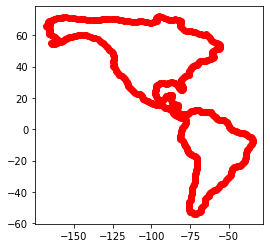

In [106]:
import geopandas
%matplotlib inline
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['lon.ns'], df['lat.ns']))
gdf = gdf.set_crs("+proj=longlat +datum=WGS84 +no_defs", allow_override=True)
gdf.plot(color='red')

Step 1. Create a geodateframe with a geometry column that is the points in Wintri Tripel crs.

In [112]:
gdf['name']=gdf.index

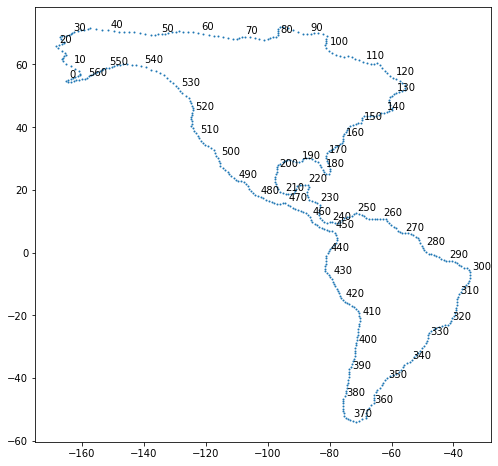

In [122]:

gdf_sub = gdf.iloc[np.arange(0,567,10)]
ax = gdf.plot(figsize=(10,8), markersize=1)
for x, y, label in zip(gdf_sub.geometry.x, gdf_sub.geometry.y, gdf_sub.name):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")